# Introduction

The applications of brain tumour classification can be mainly divided into two categories:
- Classification of brain images into normal and abnormal classes, i.e. whether the brain images contain tumours or not. 
- Classification within abnormal brain images, in other words, discrimination between different types of brain tumours.

We are in the second case here, which is generally a relatively hard and challenging problem compared with binary classification (normal and abnormal). The important of this study is also contain by the fact of some tumors can be benign, there are extrinsic cerebral tumors that do not infiltrate surrounding parenchyma, compare to others, that are malignant, intrinsic cerebral tumors that may cause tumor-infiltrative edema.

Moreover, conventional diagnoses of brain tumor images are made by human interpretation, which heavily relies on the experience of radiologists who review and analyze the characteristics of the images. Consequently, interobserver and intraobserver variability are inevitable. That's why computer-aided diagnosis system can be very interesting to reduce the number of errors and help the diagnostic decision.

This brain tumor dataset containing 3064 images from 233 patients with three kinds of brain tumor: meningioma (708 slices), glioma (1426 slices), and pituitary tumor (930 slices). The original data can be found following this link: [figshare-brain-tumor-detection](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427).

The objective of this project is to build a classifier to classify each type of tumor.

In [1]:
# Imports
import random
import zipfile
import io
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
# Constants
IMAGE_SHAPE = (512, 512)

LABELS_NAME = {
    1 : "Meningioma",
    2 : "Glioma",
    3 : "Pituitary"
}

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

EPOCHS = 10

In [16]:
def show_image(images: np.ndarray, labels: np.ndarray, border: list, names: dict=LABELS_NAME) -> None:
    """Take the a random image and plot it, with as title the class label of the image. Add
    also the border of the tumor.

    Args:
        images (ndarray):
        labels (ndarray):
        border (list):
        names (dict):
            Defaults to LABELS_NAME.
    """
    # Get a random index
    idx = random.randint(0, len(images))

    # Get the delimitation tumor
    obj = border[idx]

    # Get x and y axis
    x_axis = obj[0, 1::2]
    y_axis = obj[0, ::2]
    
    # Plot a random image
    plt.figure(figsize=(6,6))
    plt.imshow(images[idx], cmap='gray')
    plt.plot(x_axis, y_axis, ls='--', c='y', lw=3)
    plt.title(f"Class: {names[labels[idx]]}")
    plt.axis('off')
    plt.show()
    
def predict_image(images: np.ndarray, labels: np.ndarray, prediction: np.ndarray) -> None:
    """Take the a random image and plot it, with as title the predicted value 
    of the image.

    Args:
        images (ndarray):
        labels (ndarray):
        prediction (ndarray):
    """
    # Get a random index
    idx = random.randint(0, len(images))
                   
    # Plot a random image
    plt.figure(figsize=(6,6))
    plt.imshow(images[idx],  cmap='gray')
    plt.title(f"True class: {labels[idx]} \n Predicted class: {prediction[idx]}")
    plt.axis('off')
    plt.show()

@tf.function
def map_image(image: np.ndarray, label: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Cast image type to float32 and normalize it. Note that the function is decorated to enable 
    graph mode in Tensorflow.

    Args:
        image (ndarray): The array of images.
        label (ndarray): The array of labels

    Returns:
        ndarray: The array of images casted and normalized.
        ndarray: The unchanged array of labels.
    """
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    image = tf.image.grayscale_to_rgb(image)

    return image, label

def train_one_step(
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Adam,
    x: tf.Tensor, 
    y: tf.Tensor, 
    train_loss: tf.keras.losses.SparseCategoricalCrossentropy, 
    train_accuracy: tf.keras.metrics.SparseCategoricalAccuracy
) -> tf.keras.losses.SparseCategoricalCrossentropy:
    """Trains on a batch of images for one step.
    
    Args:
        model (Model): CNN classifier.
        optimizer (Adam): optimizer to use during training.
        x (Tensor): training images.
        y (Tensor): training labels.
        train_loss (keras Loss): loss object for training.
        train_accuracy (keras Metric): accuracy metric for training.

    Returns:
        SparseCategoricalCrossentropy : loss object calculated during training.
    """
    with tf.GradientTape() as tape:
        # Run the model on input x to get predictions
        predictions = model(x)
        # Compute the training loss
        loss = train_loss(y_true=y, y_pred=predictions)

    # Compute the gradients on model variables
    grads = tape.gradient(loss, model.trainable_weights)
    
    # Apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Call the train accuracy object on ground truth and predictions
    train_accuracy(y, predictions)

    return loss

# Decorate this function to enable autograph on the training loop
@tf.function
def train(
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Adam,
    epochs: int,
    device: str, 
    train_ds: tf.data.Dataset, 
    train_loss: tf.keras.losses.SparseCategoricalCrossentropy, 
    train_accuracy: tf.keras.metrics.SparseCategoricalAccuracy, 
    valid_ds: tf.data.Dataset, 
    val_loss: tf.keras.losses.SparseCategoricalCrossentropy, 
    val_accuracy: tf.keras.metrics.SparseCategoricalAccuracy
):
    """Performs the entire training loop. Prints the loss and accuracy per step and epoch. Note
    that the function is decorated to enable graph mode in Tensorflow.
    
    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        epochs (int) -- number of epochs
        train_ds (tf Dataset) -- the train set containing image-label pairs
        train_loss (keras Loss) -- loss function for training
        train_accuracy (keras Metric) -- accuracy metric for training
        valid_ds (Tensor) -- the val set containing image-label pairs
        val_loss (keras Loss) -- loss object for validation
        val_accuracy (keras Metric) -- accuracy metric for validation
    """
    loss = 0.0

    for epoch in range(epochs):
        for x, y in train_ds:
            # Training step number increments at each iteration
            with tf.device(device_name=device):
                # Run one training step
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
            
        # Print the training step number, loss and accuracy
        tf.print('EPOCH:', epoch)
        tf.print('train loss:', loss, '- train accuracy:', train_accuracy.result())

        with tf.device(device_name=device):
            for x, y in valid_ds:
                # Call the model on the batches of inputs x and get the predictions
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)
        
        # Print the validation loss and accuracy
        tf.print('val loss:', loss, '- val accuracy:', val_accuracy.result())

## Data loading

In [4]:
# Define a list to store the image, label, and border arrays 
image_list, label_list, border_list  = [[] for _ in range(3)]
# Define the list of zip files
zip_folders = [folder for folder in os.listdir('./data/') if folder.endswith('.zip')]

for folder in zip_folders: 
    # Read zip file (without unzip it)
    with zipfile.ZipFile(os.path.join('data', folder), 'r') as zip_ref:
        # Get the list of .mat file in the zip folder
        mat_files = zip_ref.namelist()

        # Get the number of images
        num_files = len(mat_files)
        
        # Make a for loop
        for image in mat_files:
            # Open the first file in the zip folder
            with zip_ref.open(image) as image_bytes:
                
                # Load the .mat file using h5py
                with h5py.File(io.BytesIO(image_bytes.read()), 'r') as image_h5:
                    
                    # Get a dictionary of all the data in the file structure
                    data = image_h5['cjdata']

                    # Get the image, label and border and save in h5 object
                    data_img = data['image']
                    data_label = data['label']
                    data_broder = data['tumorBorder']

                    # Store h5 content in numpy arrays
                    img = np.array(data_img[:], dtype=np.uint8)
                    label = np.array(data_label[:], dtype=np.uint8)
                    border = np.array(data_broder[:], dtype=np.float32)

                    # Resize the img to a standard size
                    img_resized = cv2.resize(img, IMAGE_SHAPE)

                    # Append arrays to storage list
                    image_list.append(img_resized)
                    label_list.append(label)
                    border_list.append(border)

# Assertion on list length
assert len(image_list) == len(label_list) == len(border_list)

In [23]:
# Concatenate the list of images into a single numpy array
images = np.expand_dims(np.stack(image_list), axis=3)
# Convert the labels list to a numpy array
labels = np.array(label_list).reshape(-1)

print(f"Image shape: {images.shape}")
print(f"Label shape: {labels.shape}")

Image shape: (3064, 512, 512, 1)
Label shape: (3064,)


## Exploratory Data Analysis

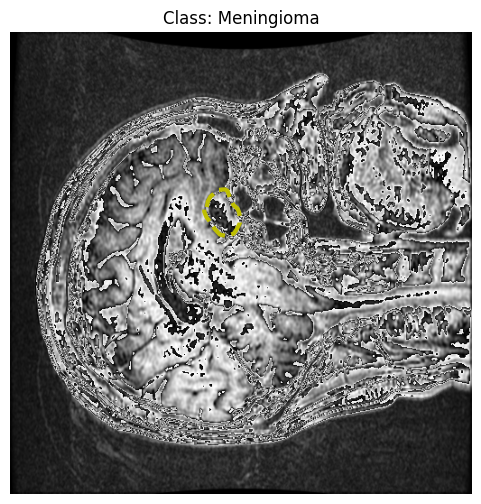

In [8]:
# Plot an image
show_image(images, labels, border_list)

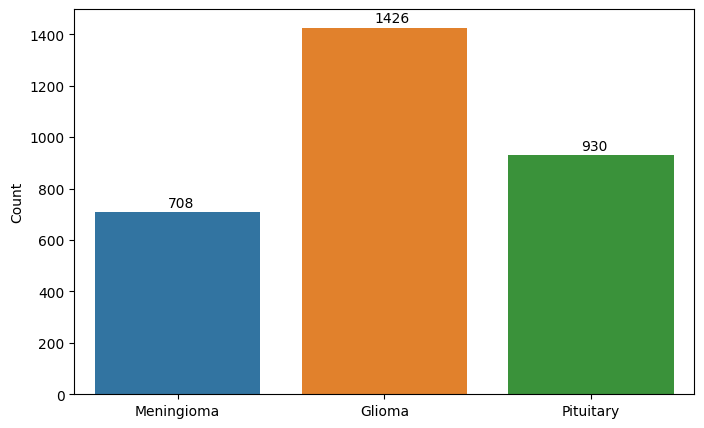

In [9]:
# Repartition of the classes across the dataset
_, counts = np.unique(labels, return_counts=True)

# Plot classes counts
plt.figure(figsize=(8, 5))
sb.barplot(x=list(LABELS_NAME.values()), y=counts)
for i, j in enumerate(counts):
    plt.text(i-0.05, j+20, str(j))
plt.ylabel('Count')
plt.show()

## Preprocessing

In [24]:
# Load the dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.map(map_image).shuffle(SHUFFLE_BUFFER_SIZE, seed=42).batch(BATCH_SIZE)

# Define train, val, test size
dataset_size = len(images)

train_size = int(TRAIN_SIZE * dataset_size)
val_size = int(VAL_SIZE * dataset_size)
test_size = int(TEST_SIZE * dataset_size)

# Split dataset into train, val and test sets
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [25]:
# Check shape of the first 5 batch
for item in train_dataset.take(5):
    print(next(iter(item)).shape)

(128, 512, 512, 3)
(128, 512, 512, 3)
(128, 512, 512, 3)
(128, 512, 512, 3)
(128, 512, 512, 3)


## Modeling

In [38]:
# Load ResNet50 model
pre_trained_model = ResNet50(
    input_shape=IMAGE_SHAPE + (3, ),
    include_top=False
)

# Freez ResNet50 layers
for layer in pre_trained_model.layers:
    layer.trainable = False

In [35]:
# Model definition
last_output = pre_trained_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=pre_trained_model.input, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [36]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam()
# Define losses
train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
val_loss = tf.keras.losses.SparseCategoricalCrossentropy()
# Define metrics
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [37]:
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
print(device)

/cpu:0


In [ ]:
train(
    model,
    optimizer,
    EPOCHS,
    device,
    train_dataset,
    train_loss,
    train_accuracy,
    val_dataset,
    val_loss,
    val_accuracy
)